In [193]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

from utils import process_experiment, open_spots_csv
sns.set_theme(context = 'talk',
              style = 'ticks')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
param_file_paths = ['/Users/shurlimann/Documents/Garner_lab_projects/dnaN/data/2021-12-07_bYS1143_S750_glucose_rep1/params.yaml',
                    '/Users/shurlimann/Documents/Garner_lab_projects/dnaN/data/2021-12-07_bYS1143_S750_glucose_rep2/params.yaml',
                    '/Users/shurlimann/Documents/Garner_lab_projects/dnaN/data/2021-10-28_bYS1143_S750_glycerol_rep1/params.yaml',
                    '/Users/shurlimann/Documents/Garner_lab_projects/dnaN/data/2021-10-28_bYS1143_S750_glycerol_rep2/params.yaml',
                    '/Users/shurlimann/Documents/Garner_lab_projects/dnaN/data/2021-10-29_bYS1148_S750_glycerol_30mMxylose_rep1/params.yaml',
                    '/Users/shurlimann/Documents/Garner_lab_projects/dnaN/data/2021-10-29_bYS1148_S750_glycerol_30mMxylose_rep2/params.yaml',
                    '/Users/shurlimann/Documents/Garner_lab_projects/dnaN/data/2021-10-29_bYS1149_S750_glycerol_30mMxylose_rep1/params.yaml',
                    '/Users/shurlimann/Documents/Garner_lab_projects/dnaN/data/2021-10-29_bYS1149_S750_glycerol_30mMxylose_rep2/params.yaml',
                    '/Users/shurlimann/Documents/Garner_lab_projects/dnaN/data/2021-10-29_bYS1152_S750_glycerol_30mMxylose_rep1/params.yaml',
                    '/Users/shurlimann/Documents/Garner_lab_projects/dnaN/data/2021-10-29_bYS1152_S750_glycerol_30mMxylose_rep2/params.yaml']

#for param_file_path in param_file_paths[:]:
#    process_experiment(param_file_path, debug_foci=False)


# open the information about the dnaN spots and filter spots based on how big the spot is
# (the spot must be bigger than the diffraction limit, otherwise we infer that it is just
# noise) and the brightness of the spot relative to the brightness of the cell
spots = open_spots_csv(param_file_paths)
true_spots = spots[(spots.max_med_ratio > 1.5) &
                   (spots.r_gaussian > 1)].copy()

# Displaying data for sanity check

We display histograms of the spot intensity.

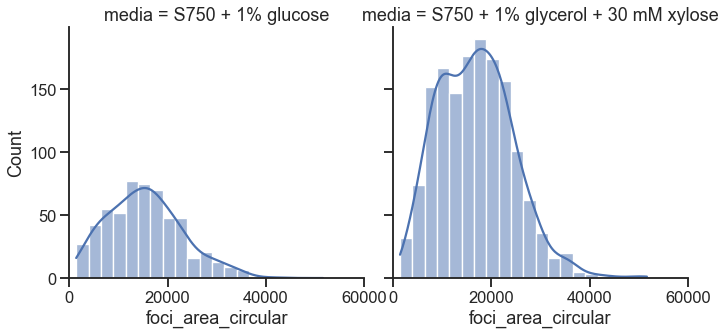

In [194]:
g = sns.displot(data = true_spots,
                 x = 'foci_area_circular',
                 col = 'media',
                 kde = True,
                 alpha = 0.5,
                 kde_kws = {'bw_adjust': 1.2}, 
                 bins = 20)
plt.xlim([0, 60000])
sns.despine(bottom = False, left = False)

## Applying a Bayesian Gaussian mixture model and calculating foci per cell & foci per area

Models the distribution of spot intensity as the sum of n = 2 Gaussians. We use the sklearn function GaussianMixture to estimate the parameters of the two Gaussians. We have the option to either: a) applying a different model to each media condition or b) applying the same model to all data. We choose b) because different medias have radically different number of spots and because we correct for differences in illumination intensity when collecting images

Given the shape of the curves and what others have done in the past ([Si et al.](https://www.sciencedirect.com/science/article/pii/S0960982217302919)), we only apply n = 2 Gaussians as opposed to something more advanced.

Cell width is obtained from from Supplementary table 6 from [Dion et al.](https://static-content.springer.com/esm/art%3A10.1038%2Fs41564-019-0439-0/MediaObjects/41564_2019_439_MOESM1_ESM.pdf)

In [132]:
# applying the same Gaussian mixture model to all data, unweighted.

n = 2
X = true_spots.loc[:, 'foci_area_circular'].values.reshape(-1, 1)

gmm = GaussianMixture(n_components=n).fit(X)

#cov = [gmm.covariances_[i] for i in range(gmm.n_components)]
means = [gmm.means_[i] for i in range(gmm.n_components)]
n_foci = np.argsort([i[0] for i in means]) + 1

true_spots.loc[:, 'foci'] = n_foci[gmm.predict(X)]


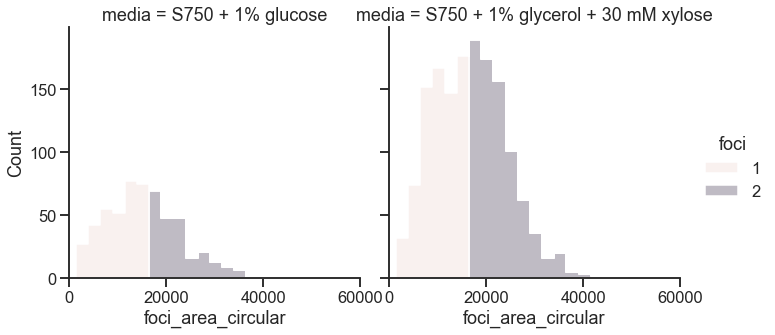

In [143]:
g = sns.displot(data = true_spots,
                 x = 'foci_area_circular',
                col = 'media',
                 hue = 'foci',
                 kde = False,
                 alpha = 0.3,
                multiple = 'stack',
                 element = 'step',
                 kde_kws = {'bw_adjust': 1.2},
                 bins = 20)
plt.xlim([0, 60000])
sns.despine(bottom = False, left = False)


In [166]:
# applying a conversion factor of 0.11 µm/pixel for the 60x microscope and a cell width of 0.75 µm
# based on the data from Dion et al.
px_size = 0.11
cell_width = 0.75470

# calculating number of foci for each cell
foci_data = pd.pivot_table(true_spots,
                            values = 'foci',
                            index = ['base_dir', 'media', 'strain', 'FOV', 'cell_id', 'cell_size'],
                            aggfunc = np.sum)
foci_data = foci_data.reset_index()
foci_data = foci_data.reset_index(drop = True)
foci_data.loc[:, 'area (micron^2)'] = foci_data.cell_size * (px_size ** 2)
foci_data.loc[:, 'volume (micron^3)'] = foci_data['area (micron^2)'] * cell_width * np.pi / 4
foci_data.loc[:, 'foci per volume (micron^3)'] = foci_data['foci'] / foci_data['volume (micron^3)']

## Summarizing and plotting the data

In [177]:
foci_data['genotype'] = foci_data.strain.map({'bYS1143' : 'WT',
                                              'bYS1148' : 'MurAA OE',
                                              'bYS1149' : 'RodZ(S85E)',
                                              'bYS1152' : 'PrkC OE'})
foci_data['media'] = foci_data['media'].str.replace(' \+ 1\%', '')
foci_data['media'] = foci_data['media'].str.replace(' \+ 30 mM xylose', '')
foci_data['condition'] = foci_data.genotype + ' in ' + foci_data.media

foci_per_volume = foci_data[['condition',
                              'foci per volume (micron^3)']].groupby('condition')
mean_foci = foci_per_volume.mean()
mean_foci.columns = ['mean foci per volume (micron^3)']
std_foci = foci_per_volume.std()
std_foci.columns = ['std foci per volume (micron^3)']
foci_summary = pd.concat([mean_foci, std_foci], axis = 1)
foci_gr = pd.read_csv('/Users/shurlimann/Documents/Garner_lab_projects/dnaN/data/dnaN_strains_growthrate.csv',
                      index_col=0)
foci_summary = pd.concat([foci_summary, foci_gr], axis = 1)

/var/folders/1c/jtcylk515p5c26hctjb929th0000gp/T/ipykernel_38108/2045362316.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  foci_data['media'] = foci_data['media'].str.replace(' \+ 1\%', '')
/var/folders/1c/jtcylk515p5c26hctjb929th0000gp/T/ipykernel_38108/2045362316.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  foci_data['media'] = foci_data['media'].str.replace(' \+ 30 mM xylose', '')


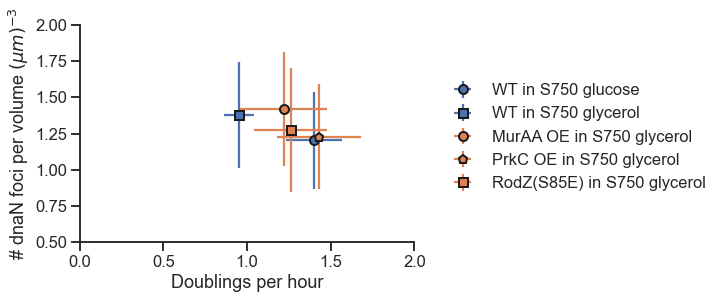

In [195]:
palette = sns.color_palette(n_colors = 2)
foci_summary['color'] = [palette[0] if 'WT' in i else palette[1] for i in foci_summary.index]
foci_summary = foci_summary.sort_values(by = 'color')
foci_summary['markers'] = ['o', 's', 'o', 'p', 's']
fig, ax = plt.subplots(1, 1)
for cond, cond_data in foci_summary.iterrows():
    color = cond_data['color']
    plt.errorbar(x = cond_data['gr'],
                 y = cond_data['mean foci per volume (micron^3)'],
                 xerr = cond_data['std gr'],
                 yerr = cond_data['std foci per volume (micron^3)'],
                 marker = cond_data['markers'],
                 color = color,
                 mec = 'k',
                 mew = 2,
                 label = cond,
                 ls = 'none')
ax.set(xlim = (0, 2),
       ylim = (0.5, 2),
       xlabel = 'Doublings per hour',
       ylabel = r'# dnaN foci per volume $(µm)^{-3}$')
plt.legend(loc='upper left',
           bbox_to_anchor=(1.05, 0.8),
           frameon = False)
sns.despine(bottom = False, left = False)